This is a notebook with all experiments in the DEDPUL paper on synthetic data sets

In [1]:
import numpy as np
import pandas as pd
import random

import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from IPython import display
%matplotlib inline

from itertools import chain
from scipy.stats import norm, laplace
from scipy.stats import gaussian_kde
from scipy.stats import linregress
from scipy.optimize import minimize

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import cross_val_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, brier_score_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, balanced_accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from scipy.stats import t
from statsmodels.stats.multitest import multipletests

from algorithms import *
from utils import *
from KMPE import *
from NN_functions import *

from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm as tqdm

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: F

# DEDPUL, EN, and nnPU

In [2]:
def experiment_synthetic(mix_size=10000, pos_size=1000, alphas=None, dmu=None, ds=None, distribution='laplace', 
                         n_networks=1, n_rep=10, find_alpha=False, random_state=0):
    """
    :param distribution: 'normal' or 'laplace'
    """
    
    # defaults
    if alphas is None:
        alphas = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    if dmu is None:
        dmu = [1, 2, 4]
    if ds is None:
        ds = [2, 4]
        
    params = []
    for mu in dmu:
        params.append((mu, 1))
    for s in ds:
        params.append((0, s))
    
    np.random.seed(random_state)
    n_seeds = len(alphas) * len(params) * n_rep
    seeds = np.arange(n_seeds)
    np.random.shuffle(seeds)
    np.random.seed(None)
    
    fixed_alpha = None
    results = []
    for mu, s in tqdm(params):
        for alpha in tqdm(alphas):
            if s == 1:
                kernel = 'linear'
            else:
                kernel = 'poly'
            for i in range(n_rep):
                random_state, seeds = seeds[-1], seeds[:-1] # pop analogue
                
                data, target_pu, target_mix = generate_data(mix_size, pos_size, alpha, random_state=random_state, 
                                                            delta_mu=mu, multiplier_s=s, distribution=distribution)
                target_mix = target_mix[target_mix != 2]
                
                cons_alpha = estimate_cons_alpha(mu, s, alpha, distribution)
                cons_poster =  estimate_cons_poster(data[target_pu == 1].reshape(-1,), 
                                                    mu, s, distribution, alpha, cons_alpha)
                    
                
                if not find_alpha:
                    fixed_alpha = cons_alpha
                res = dict()
                res = estimate_poster_cv(data, target_pu, estimator='ntc_methods', alpha=fixed_alpha,
                                         estimate_poster_options={'disp': False},
                                         estimate_diff_options={
                                             'MT': True, 'MT_coef': 0.25, 'decay_MT_coef': False, 'tune': False,
                                             'bw_mix': 0.05, 'bw_pos': 0.1, 'threshold': 'mid', 
                                             'n_gauss_mix': 20, 'n_gauss_pos': 10,
                                             'bins_mix': 20, 'bins_pos': 20, 'k_neighbours': None,},
                                         
                                         estimate_preds_cv_options={
                                             'n_networks': n_networks,
                                             'cv': 5,
                                             'random_state': random_state,
                                             'hid_dim': 16,
                                             'n_hid_layers': 0,
                                             'lr': 1e-3,
                                             'l2': 1e-4,
                                             'bn': False,
                                         },
                                         train_nn_options = {
                                             'n_epochs': 100, 'loss_function': 'log', 'batch_size': 64,
                                             'n_batches': None, 'n_early_stop': 5, 'disp': False,
                                         }
#                                          ### for catboost - comment code above and uncomment below;
#                                          ### similar changes in estimate_poster_cv also recquired
#                                          estimate_preds_cv_options={
#                                              'n_networks': n_networks,
#                                              'cv': 5,
#                                              'random_state': random_state,
#                                              'n_early_stop': 20,
#                                              'catboost_params': {
#                                                  'iterations': 250, 'depth': 4, 'learning_rate': 0.1, 
#                                                  'l2_leaf_reg': 10
#                                              },
#                                          }
                                
                                        )

                
                res['nnre_sigmoid'] = estimate_poster_cv(data, target_pu, estimator='nnre', alpha=cons_alpha,
                                                 estimate_preds_cv_options={
                                                     'n_networks': n_networks,
                                                     'cv': 5,
                                                     'random_state': random_state,
                                                     'hid_dim': 16,
                                                     'n_hid_layers': 0,
                                                     'lr': 1e-3,
                                                     'l2': 1e-4,
                                                     'bn': False,
                                                 },
                                                 train_nn_options = {
                                                     'n_epochs': 150, 'batch_size': 64, 'loss_function': 'sigmoid',
                                                     'n_batches': None, 'n_early_stop': 10, 'disp': False,
                                                     'beta': 0.1, 'gamma': 0.9,
                                                 }
                                                )
                
                res['nnre_brier'] = estimate_poster_cv(data, target_pu, estimator='nnre', alpha=cons_alpha,
                                                 estimate_preds_cv_options={
                                                     'n_networks': n_networks,
                                                     'cv': 5,
                                                     'random_state': random_state,
                                                     'hid_dim': 16,
                                                     'n_hid_layers': 0,
                                                     'lr': 1e-3,
                                                     'l2': 1e-4,
                                                     'bn': False,
                                                 },
                                                 train_nn_options = {
                                                     'n_epochs': 150, 'batch_size': 64, 'loss_function': 'brier',
                                                     'n_batches': None, 'n_early_stop': 10, 'disp': False,
                                                     'beta': 0.1, 'gamma': 0.9,
                                                 }
                                                )
                
                for key in res.keys():
                    est_alpha, poster = res[key]
                    
                    cur_result = [distribution, key, i, mu, s, alpha, cons_alpha, est_alpha]
                    if poster is not None:
                        cur_result.append(np.mean(poster))
                        cur_result.append(accuracy_score(target_mix, poster.round()))
                        cur_result.append(roc_auc_score(target_mix, poster))
                        cur_result.append(mean_absolute_error(cons_poster, poster))
                        cur_result.append(np.sqrt(mean_squared_error(cons_poster, poster)))
                        cur_result.append(log_loss(target_mix, poster))
                        cur_result.append(precision_score(target_mix, poster.round()))
                        cur_result.append(recall_score(target_mix, poster.round()))
                        cur_result.append(balanced_accuracy_score(target_mix, poster.round()))
                        cur_result.append(brier_score_loss(target_mix, poster))
                    results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['distribution', 'estimator', 'random_state', 
                                                'dmu', 'ds', 'alpha', 'cons_alpha', 'est_alpha', 'mean_poster',
                                                'accuracy', 'roc', 'mae', 'rmse', 'log_loss', 'precision', 'recall',
                                                'accuracy_balanced', 'brier_score',])
    return df_results

In [10]:
res = experiment_synthetic(random_state=100)

res = res.round(5)
res.to_csv('exp_synth.csv', index=False, sep=';', decimal=',')

# KMPE

In [4]:
def experiment_synthetic_KM(mix_size=3000, pos_size=1000, alphas=None, dmu=None, ds=None, distribution='laplace', 
                                n_rep=10, max_sample=4000, **kwargs):
    """
    :param distribution: 'normal' or 'laplace'
    """
    
    # defaults
    if alphas is None:
        alphas = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    if dmu is None:
        dmu = [1, 2, 4]
    if ds is None:
        ds = [2, 4]
        
    params = []
    for mu in dmu:
        params.append((mu, 1))
    for s in ds:
        params.append((0, s))
        
    results = []
    for mu, s in tqdm(params):
        for alpha in tqdm(alphas):
            for i in range(n_rep):
                data, target_pu, target_mix = generate_data(mix_size, pos_size, alpha, random_state=i, 
                                                            delta_mu=mu, multiplier_s=s, distribution=distribution)
                cons_alpha = estimate_cons_alpha(mu, s, alpha, distribution)
                

                data_pos = data[target_pu == 0]
                data_mix = data[target_pu == 1][np.random.randint(0, int(target_pu.sum()), 
                                                                  max_sample - int((1-target_pu).sum()))]
                try:
                    KM_2 = 1 - wrapper(data_mix, data_pos, disp=False, 
                                        KM_1=False, KM_2=True, lambda_lower_bound=0.5, lambda_upper_bound=10)
                except ValueError as e:
                    KM_2 = np.nan
                    print(e)
                
                cur_result = [distribution, i, mu, s, alpha, cons_alpha, KM_2]
                results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['distribution', 'random_state', 
                                                'dmu', 'ds', 'alpha', 'cons_alpha', 'est_alpha'])
    df_results['estimator'] = 'KM'
    return df_results

In [11]:
res_KM = experiment_synthetic_KM()

res_KM = res_KM.round(5)
res_KM.to_csv('exp_synth_KM.csv', index=False, sep=';', decimal=',')

## TIcE

In [20]:
from TIcE import tice, tice_c_to_alpha, min_max_scale

def experiment_synthetic_TIcE(mix_size=10000, pos_size=1000, alphas=None, dmu=None, ds=None, distribution='laplace', 
                                n_rep=10, NTC=False, **kwargs):
    """
    :param distribution: 'normal' or 'laplace'
    """
    
    # defaults
    if alphas is None:
        alphas = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    if dmu is None:
        dmu = [1, 2, 4]
    if ds is None:
        ds = [2, 4]
        
    params = []
    for mu in dmu:
        params.append((mu, 1))
    for s in ds:
        params.append((0, s))
        
    results = []
    for mu, s in tqdm(params):
        for alpha in tqdm(alphas):
            for i in range(n_rep):
                data, target_pu, target_mix = generate_data(mix_size, pos_size, alpha, random_state=i, 
                                                            delta_mu=mu, multiplier_s=s, distribution=distribution)
                gamma = target_pu.sum() / target_pu.shape[0]
                if NTC:
                    data = estimate_preds_cv(
                                data, target_pu, cv=5, l2=1e-4
                                n_networks=1, hid_dim=16, n_hid_layers=0, lr=1e-4, bn=False,
                                train_nn_options={'n_epochs': 200, 'metric': roc_auc_loss, 'batch_size': 64,
                                                  'n_batches': None, 'n_early_stop': 10, 'disp': False, 
                                                  'loss_function': 'log'}).reshape(-1, 1)
                else:
                    data = min_max_scale(data)
                cons_alpha = estimate_cons_alpha(mu, s, alpha, distribution)
                
                c = tice(data, 1 - target_pu, 10, np.random.randint(10, size=len(data)),
                         delta=.2, maxSplits=500, minT=10, n_splits=40)[0]
                alpha_tice = tice_c_to_alpha(c, gamma)
                
                cur_result = [distribution, i, mu, s, alpha, cons_alpha, alpha_tice]
                results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['distribution', 'random_state', 
                                                'dmu', 'ds', 'alpha', 'cons_alpha', 'est_alpha'])
    df_results['estimator'] = 'tice'
    return df_results

In [12]:
res_tice = experiment_synthetic_TIcE(NTC=False)
res_tice = res_tice.round(5)
res_tice['est_alpha'][res_tice['est_alpha'] < 0] = 0
res_tice.to_csv('TIcE_synth.csv', index=False, sep=';', decimal=',')

# The data set with all results

In [2]:
# this is a merged data set with all experiments with all methods
res = pd.read_csv('exp_synth_new_merged.csv', sep=';', decimal=',')

In [6]:
res['alpha_mae'] = (res['cons_alpha'] - res['est_alpha']).abs()
res_grouped = res.groupby(['distribution', 'ds', 'dmu', 'alpha', 'cons_alpha', 'estimator']).mean().drop(
    ['est_alpha', 'random_state'], axis=1).reset_index()

res_pivot_alpha = res_grouped.pivot_table(index=['distribution', 'ds', 'dmu', 'alpha'],
                                          columns=['estimator'], values='alpha_mae')

res_pivot_mae = res_grouped.pivot_table(index=['distribution', 'ds', 'dmu', 'alpha'],
                                        columns=['estimator'], values='mae')
res_pivot_mae = clean_columns_poster(res_pivot_mae)


# Plots

In [7]:
# To switch between comparison of DEDPUL with SOTA and ablations of DEDPUL, comment lines under #1 and 
# uncomment lines under #2

params = ((1, 1), (2, 1), (4, 1), (0, 2), (0, 4))
def plot_results_synthetic(res_plt, distribution, ylims=None, reverse_alpha=False, save_name=None, dpi=200,
                           alpha_mode=True):
    
    if distribution == 'laplace':
        symbol = 'L'
    elif distribution == 'normal':
        symbol = 'N'
    
    if reverse_alpha:
        # by default all estimates are computed for negative priors; here convert them to positive priors
        res_plt['alpha'] = 1 - res_plt['alpha']
        
    if ylims is None:
        ylims = {}
    
    fig = plt.figure(0)
    gridspec.GridSpec(1,3)
    fig.set_size_inches(w=35, h=7)

    for i, (mu, s) in enumerate(params):
        res_plt_cur = res_plt[(res_plt['distribution'] == distribution) & (res_plt['dmu'] == mu)&(res_plt['ds'] == s)]
        plt.subplot2grid((1,5), (0,i), colspan=1, rowspan=1)
        plt.title("$f_n = {}({}, {})$".format(symbol, mu, s), fontdict={'fontsize': 23})

        if not alpha_mode:
            pass
            # 1
            plt.plot(res_plt_cur['alpha'], res_plt_cur['nnre_brier'], color='purple', marker='v', ls='--')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['nnre_sigmoid'], color='brown', marker='^', ls='-.')

        else:
            pass
            # 1
            plt.plot(res_plt_cur['alpha'], res_plt_cur['KM'], 'rs--')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['tice'], c='g', marker='v', ls='-.')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['tice+ntc'], c='b', marker='*', ls='-.')
            # 2
#             plt.plot(res_plt_cur['alpha'], res_plt_cur['baseline_dedpul'], c='r', marker='*', ls='--')

        plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul'], 'ko-')
        # 1
        plt.plot(res_plt_cur['alpha'], res_plt_cur['e3_en'], c='orange', marker='x', ls=':')
        # 2
#         plt.plot(res_plt_cur['alpha'], res_plt_cur['cat'], c='g', marker='*', ls='--')
#         plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul_GMM'], c='purple', marker='*', ls='-.')
#         plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul_hist'], c='b', marker='*', ls='-.')
#         plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul_no_heur'], c='darkcyan', marker='*', ls=':')
        
        plt.xticks((0.05, 0.25, 0.5, 0.75, 0.95), fontsize='xx-large')
        plt.xlim(0, 1)
        plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize='xx-large')
        if i in ylims.keys():
            plt.ylim(0, ylims[i])
            
        plt.xlabel(r'$\alpha$', fontsize='xx-large')
        if i == 0:
            if not alpha_mode:
                plt.ylabel(r'$avg\left| p_p^*(x) - \widetilde{p}_p^*(x)\right|$', fontsize='xx-large')
            else:
                plt.ylabel(r'$\left|\alpha^* - \widetilde{\alpha}^*\right|$', fontsize='xx-large')
                
        if i == 2:
            if not alpha_mode:
                # 1
                plt.legend(handles=(Line2D([], [], linestyle=':', color='orange', marker='x'),
                                    Line2D([], [], color='purple', marker='v', ls='--'),
                                    Line2D([], [], color='brown', marker='^', ls='-.'),
                                    Line2D([], [], linestyle='-', color='k', marker='o')),
                          labels=('EN', 'nnPU-brier', 'nnPU-sigmoid', 'DEDPUL'), 
                           loc='upper left', fontsize='xx-large')

                # 2
#                 plt.legend(handles=(Line2D([], [], linestyle='-', color='k', marker='o'),
#                                     Line2D([], [], linestyle='--', color='g', marker='*'),
#                                     Line2D([], [], linestyle='-.', color='purple', marker='*'),
#                                     Line2D([], [], linestyle='-.', color='b', marker='*'),
#                                     Line2D([], [], linestyle=':', color='darkcyan', marker='*')),
#                           labels=('DEDPUL', 'catboost', 'GMM', 'hist', 'no_smooth'), 
#                            loc='upper left', fontsize='xx-large')
            else:
                # 1
                plt.legend(handles=(Line2D([], [], linestyle=':', color='orange', marker='x'),
                                    Line2D([], [], c='g', marker='v', ls='-.'),
                                    Line2D([], [], c='b', marker='*', ls='-.'),
                                    Line2D([], [], linestyle='--', color='r', marker='s'),
                                    Line2D([], [], linestyle='-', color='k', marker='o'),
                ),
                           labels=('EN', 'TIcE', 'NTC+TIcE', 'KM2', 'DEDPUL'), 
                           loc='upper left', fontsize='xx-large')
                
                # 2
#                 plt.legend(handles=(Line2D([], [], linestyle='-', color='k', marker='o'),
#                                     Line2D([], [], linestyle='--', color='r', marker='*'),
#                                     Line2D([], [], linestyle='--', color='g', marker='*'),
#                                     Line2D([], [], linestyle='-.', color='purple', marker='*'),
#                                     Line2D([], [], linestyle='-.', color='b', marker='*'),
#                                     Line2D([], [], linestyle=':', color='darkcyan', marker='*')),
#                           labels=('DEDPUL', 'simple_alpha', 'catboost', 'GMM', 'hist', 'no_smooth'), 
#                            loc='upper left', fontsize='xx-large')


    if save_name:
        plt.savefig(save_name + '.png', dpi=dpi)
               

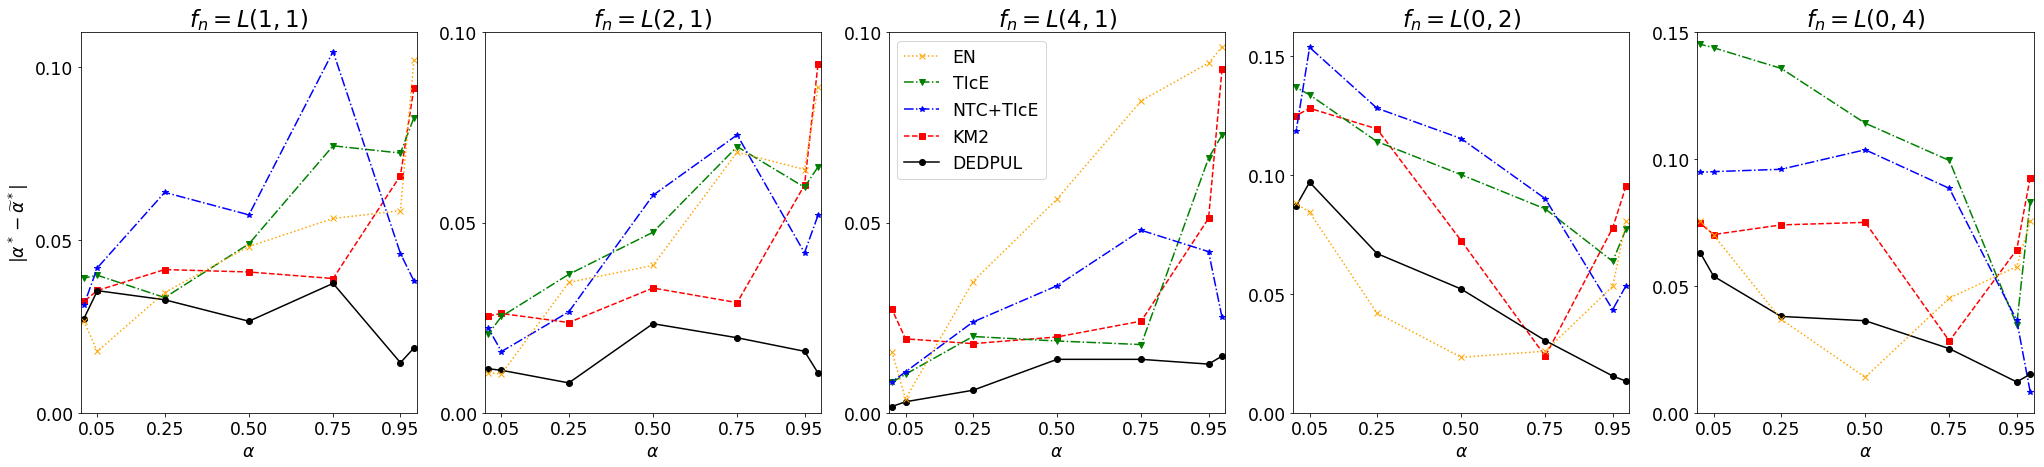

In [8]:
plot_results_synthetic(res_pivot_alpha.copy().reset_index(), 'laplace', reverse_alpha=True, alpha_mode=True,
                       ylims={0: 0.11, 1: 0.1, 2: 0.1, 3: 0.16, 4: 0.15},
##                         save_name='synth_alpha_new',
#                        ylims={0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25},
##                         save_name='synth_alpha_new_ablation',
                      )

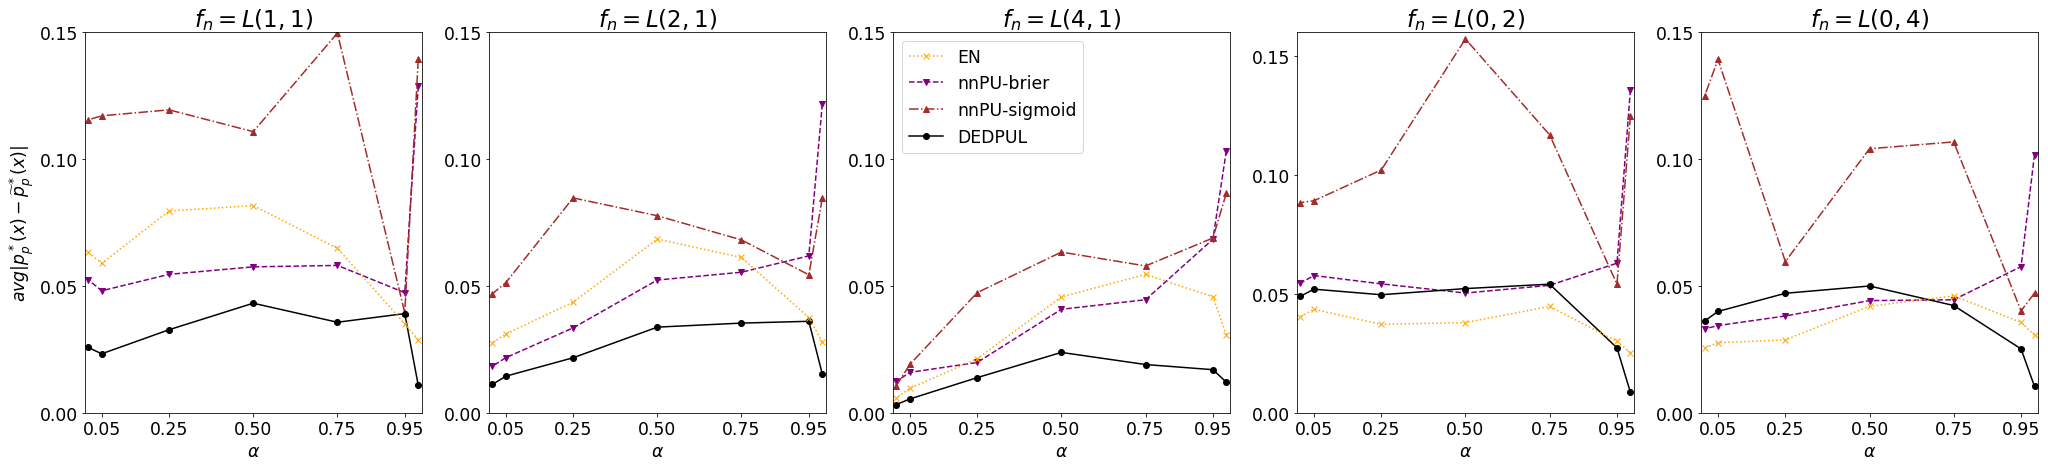

In [9]:
plot_results_synthetic(res_pivot_mae.copy().reset_index(), 'laplace', reverse_alpha=True, alpha_mode=False,
                       ylims={0: 0.15, 1: 0.15, 2: 0.15, 3: 0.16, 4: 0.15},
# #                        save_name='synth_mae_new',
#                        ylims={0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1},
# #                        save_name='synth_mae_new_ablation',
                      )